In [11]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [16]:
OUTPUT_DIR = '/home/kali/AI/'
GEOJSON_PATH = '/home/kali/AI/geoJson/geo.json'  # ← UPDATED PATH!

# Load clustering results
df_features = pd.read_csv(OUTPUT_DIR + 'fcm_features_raw.csv', index_col=0)
cluster_labels = np.load(OUTPUT_DIR + 'fcm_cluster_labels_c2.npy')
membership_matrix = np.load(OUTPUT_DIR + 'fcm_membership_c2.npy')

provinces = df_features.index.tolist()

# Determine high-risk cluster (higher CV)
feature_groups = {
    'CV': [c for c in df_features.columns if c.startswith('CV_')]
}
c0_cv = df_features[cluster_labels==0][feature_groups['CV']].mean().mean()
c1_cv = df_features[cluster_labels==1][feature_groups['CV']].mean().mean()
high_risk_cluster = 0 if c0_cv > c1_cv else 1

print(f"\n✓ Loaded: {len(provinces)} provinces")
print(f"✓ High-risk cluster: {high_risk_cluster} (CV={c0_cv if high_risk_cluster==0 else c1_cv:.4f})")
print(f"✓ Low-risk cluster: {1-high_risk_cluster} (CV={c1_cv if high_risk_cluster==0 else c0_cv:.4f})")



Loading GeoJSON...
✓ Loaded 38 provinces from GeoJSON
✓ Prepared data for 34 provinces

Generating static cluster map...
✓ Matched 34/34 provinces

✓ Saved: viz_8_geographic_map.png


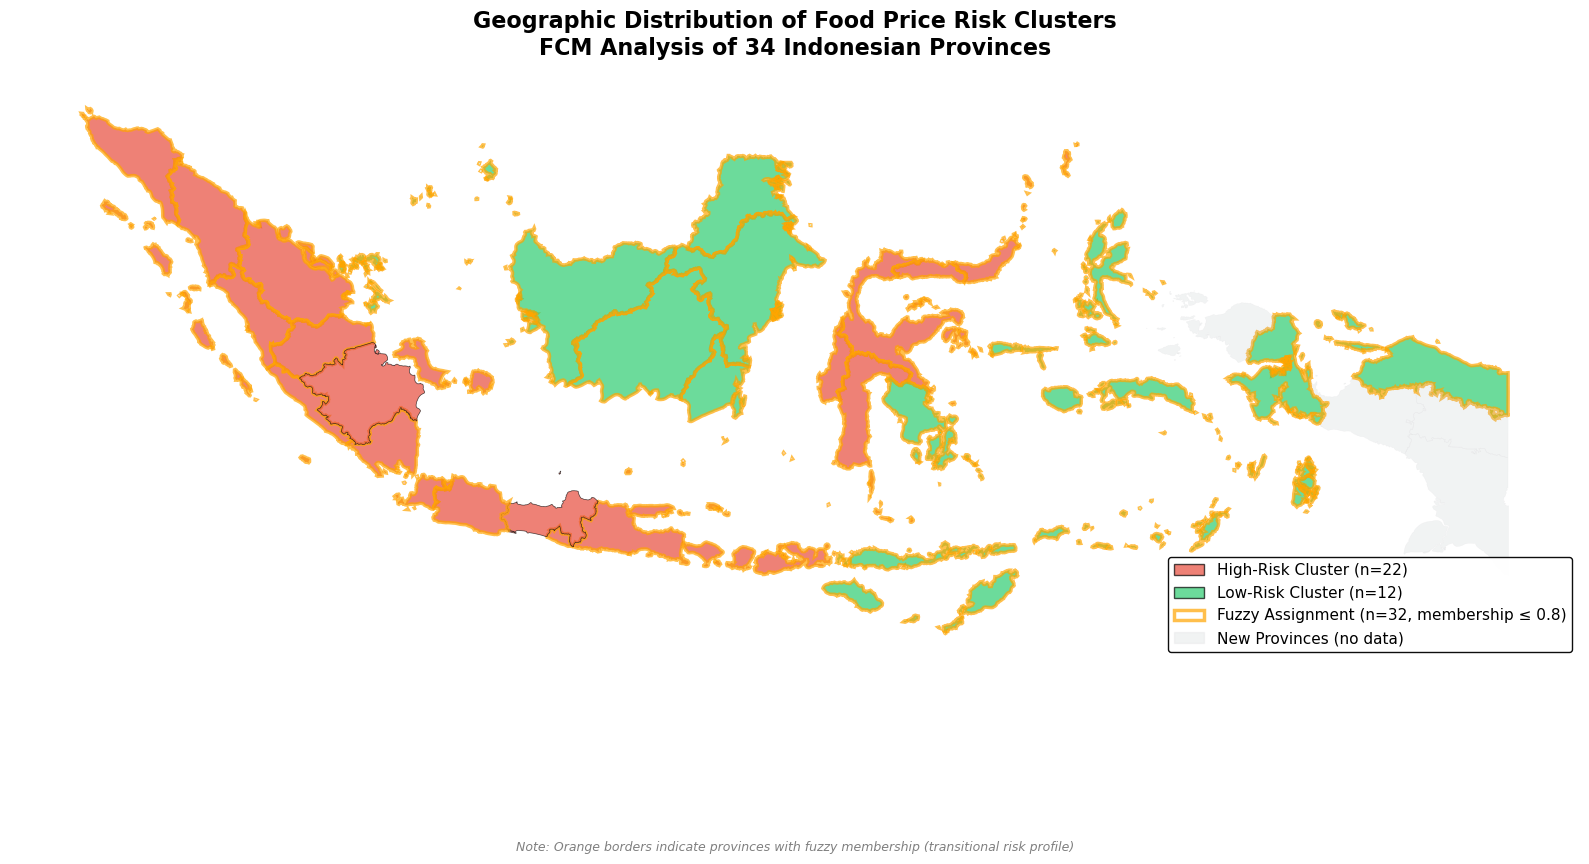

In [21]:
# ============================================================================
# 13.1: NAME MAPPING (ONLY DI YOGYAKARTA NEEDS FIXING)
# ============================================================================
name_mapping = {
    'DI Yogyakarta': 'Daerah Istimewa Yogyakarta'
}

# ============================================================================
# 13.2: LOAD GEOJSON
# ============================================================================
print("\nLoading GeoJSON...")

with open(GEOJSON_PATH, 'r', encoding='utf-8') as f:
    indonesia_geo = json.load(f)

print(f"✓ Loaded {len(indonesia_geo['features'])} provinces from GeoJSON")

# ============================================================================
# 13.3: PREPARE CLUSTER DATA
# ============================================================================
province_data = []
for i, prov in enumerate(provinces):
    assigned_cluster = cluster_labels[i]
    max_membership = membership_matrix[assigned_cluster, i]
    
    # Classify as high/low risk
    if assigned_cluster == high_risk_cluster:
        risk_label = 'High-Risk'
        risk_color = '#e74c3c'  # Red
    else:
        risk_label = 'Low-Risk'
        risk_color = '#2ecc71'  # Green
    
    # Check if fuzzy (membership <= 0.8)
    is_fuzzy = max_membership <= 0.8
    
    # Apply name mapping for GeoJSON matching
    geo_name = name_mapping.get(prov, prov)
    
    province_data.append({
        'province': prov,
        'geo_name': geo_name,
        'cluster': assigned_cluster,
        'risk_label': risk_label,
        'risk_color': risk_color,
        'membership': max_membership,
        'is_fuzzy': is_fuzzy
    })

df_map = pd.DataFrame(province_data)

print(f"✓ Prepared data for {len(df_map)} provinces")

# ============================================================================
# 13.4: CREATE STATIC MAP
# ============================================================================
print("\nGenerating static cluster map...")

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Create lookup dictionary (geo_name → color/border)
geo_lookup = {}
for _, row in df_map.iterrows():
    geo_lookup[row['geo_name']] = {
        'color': row['risk_color'],
        'is_fuzzy': row['is_fuzzy']
    }

# Draw provinces
matched_count = 0
for feature in indonesia_geo['features']:
    # Get province name from GeoJSON
    prop = feature['properties']
    geo_name = prop.get('PROVINSI') or prop.get('provinsi') or prop.get('Propinsi')
    
    # Get geometry
    geometry = feature['geometry']
    
    # Determine color
    if geo_name in geo_lookup:
        color = geo_lookup[geo_name]['color']
        alpha = 0.7
        edgecolor = 'black'
        linewidth = 0.5
        
        # Highlight fuzzy provinces with orange border
        if geo_lookup[geo_name]['is_fuzzy']:
            edgecolor = 'orange'
            linewidth = 2.5
        
        matched_count += 1
    else:
        # Unmatched or extra provinces (new pemekaran)
        color = '#bdc3c7'  # Gray
        alpha = 0.2
        edgecolor = 'lightgray'
        linewidth = 0.3
    
    # Draw polygon(s)
    if geometry['type'] == 'Polygon':
        coords = geometry['coordinates'][0]
        polygon = Polygon(coords, closed=True)
        patch = plt.Polygon(polygon.get_xy(), facecolor=color, alpha=alpha, 
                           edgecolor=edgecolor, linewidth=linewidth)
        ax.add_patch(patch)
    
    elif geometry['type'] == 'MultiPolygon':
        for polygon_coords in geometry['coordinates']:
            coords = polygon_coords[0]
            polygon = Polygon(coords, closed=True)
            patch = plt.Polygon(polygon.get_xy(), facecolor=color, alpha=alpha,
                               edgecolor=edgecolor, linewidth=linewidth)
            ax.add_patch(patch)

print(f"✓ Matched {matched_count}/{len(df_map)} provinces")

# Set map bounds
ax.autoscale()
ax.set_aspect('equal')
ax.axis('off')

# Add legend
high_count = df_map[df_map['risk_label']=='High-Risk'].shape[0]
low_count = df_map[df_map['risk_label']=='Low-Risk'].shape[0]
fuzzy_count = df_map[df_map['is_fuzzy']].shape[0]

legend_elements = [
    mpatches.Patch(facecolor='#e74c3c', alpha=0.7, edgecolor='black', 
                   label=f'High-Risk Cluster (n={high_count})'),
    mpatches.Patch(facecolor='#2ecc71', alpha=0.7, edgecolor='black', 
                   label=f'Low-Risk Cluster (n={low_count})'),
    mpatches.Patch(facecolor='white', alpha=0.7, edgecolor='orange', linewidth=2.5,
                   label=f'Fuzzy Assignment (n={fuzzy_count}, membership ≤ 0.8)'),
    mpatches.Patch(facecolor='#bdc3c7', alpha=0.2, edgecolor='lightgray', 
                   label='New Provinces (no data)')
]

ax.legend(handles=legend_elements, loc='lower right', fontsize=11, 
          frameon=True, facecolor='white', edgecolor='black', framealpha=0.95)

# Add title
plt.title('Geographic Distribution of Food Price Risk Clusters\nFCM Analysis of 34 Indonesian Provinces', 
          fontsize=16, weight='bold', pad=20)

# Add note
plt.figtext(0.5, 0.02, 
            'Note: Orange borders indicate provinces with fuzzy membership (transitional risk profile)',
            ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'viz_8_geographic_map.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: viz_8_geographic_map.png")
plt.show()


✓ Pemetaan nama: 1 provinsi perlu dikonversi
✓ Provinsi baru (belum ada data): 4 provinsi

Memuat data GeoJSON...
✓ GeoJSON dimuat: 38 provinsi
✓ Data pemetaan disiapkan: 34 provinsi

Membuat peta cluster...

📊 Status Pemetaan:
  ✓ Berhasil dipetakan: 34/34 provinsi dengan data

✓ Tersimpan: peta_cluster_risiko_pangan.png


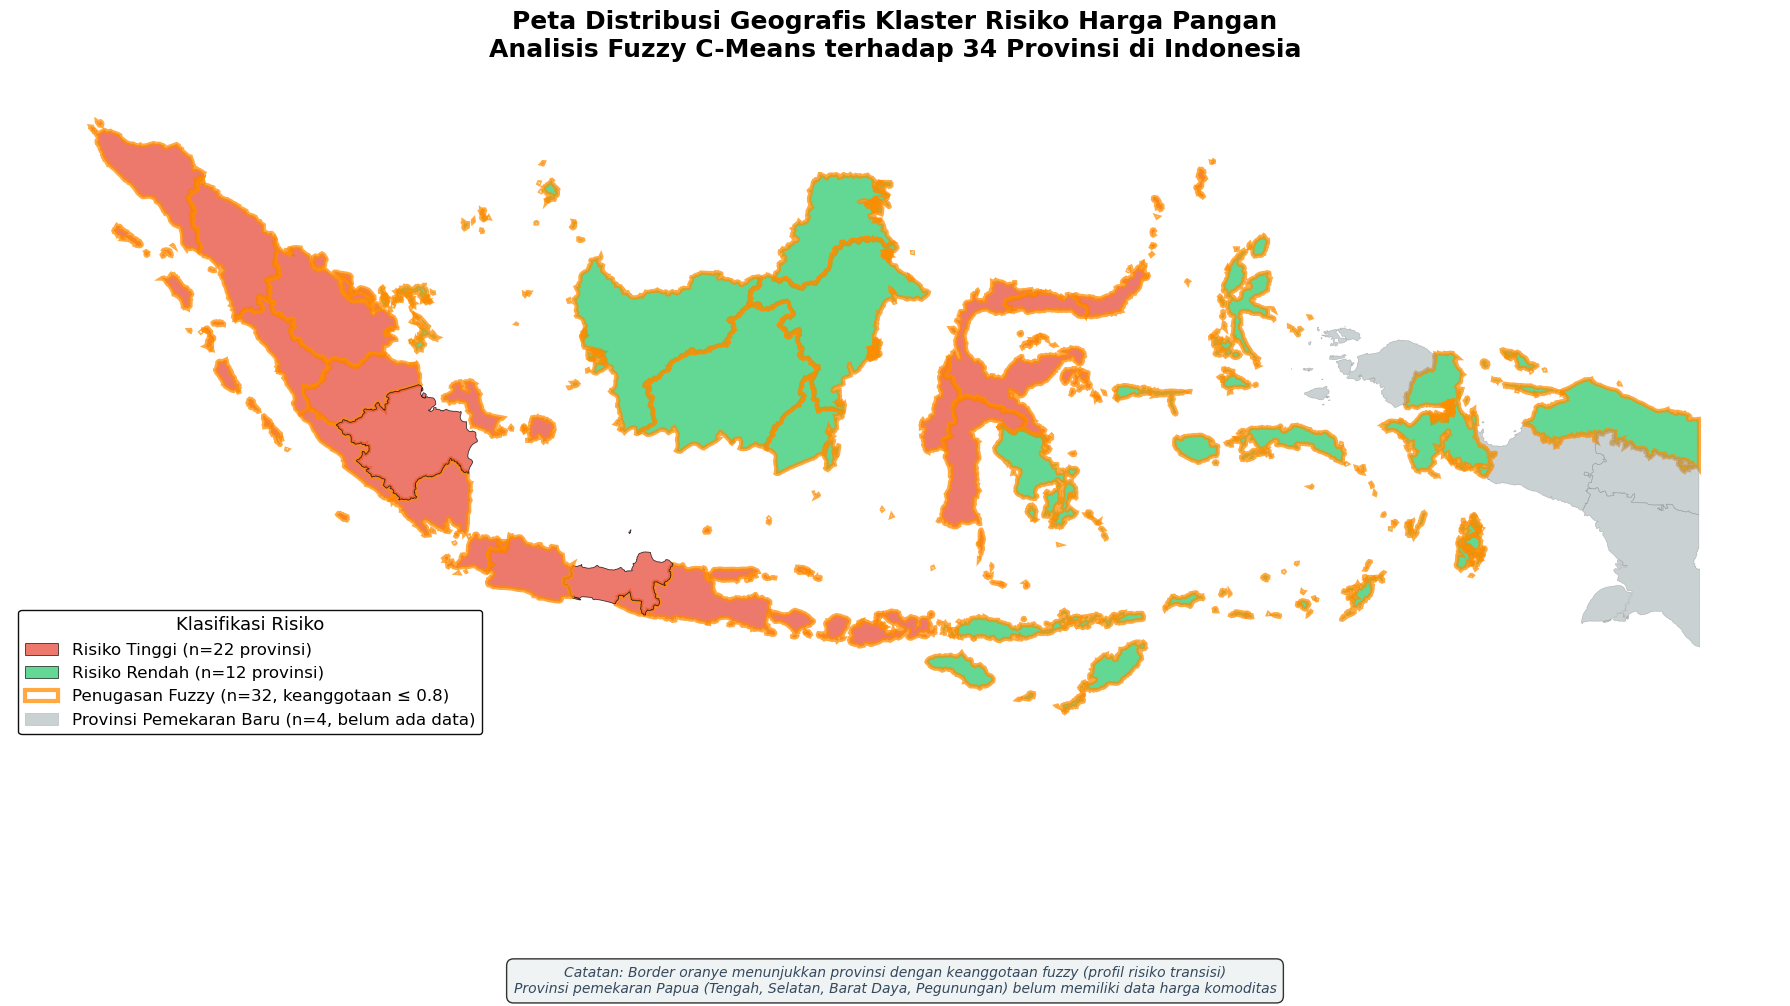

In [23]:
name_mapping = {
    'DI Yogyakarta': 'Daerah Istimewa Yogyakarta'
}

# Provinsi pemekaran baru (ada di GeoJSON tapi tidak ada data)
new_provinces = [
    'Papua Tengah', 
    'Papua Selatan', 
    'Papua Barat Daya', 
    'Papua Pegunungan'
]

print(f"\n✓ Pemetaan nama: {len(name_mapping)} provinsi perlu dikonversi")
print(f"✓ Provinsi baru (belum ada data): {len(new_provinces)} provinsi")

# ============================================================================
# LOAD GEOJSON
# ============================================================================
print("\nMemuat data GeoJSON...")

with open(GEOJSON_PATH, 'r', encoding='utf-8') as f:
    indonesia_geo = json.load(f)

print(f"✓ GeoJSON dimuat: {len(indonesia_geo['features'])} provinsi")

# ============================================================================
# PERSIAPAN DATA CLUSTERING
# ============================================================================
province_data = []
for i, prov in enumerate(provinces):
    assigned_cluster = cluster_labels[i]
    max_membership = membership_matrix[assigned_cluster, i]
    
    # Klasifikasi risiko dalam Bahasa Indonesia
    if assigned_cluster == high_risk_cluster:
        risk_label = 'Risiko Tinggi'
        risk_color = '#e74c3c'  # Merah
    else:
        risk_label = 'Risiko Rendah'
        risk_color = '#2ecc71'  # Hijau
    
    # Tandai jika fuzzy (membership <= 0.8)
    is_fuzzy = max_membership <= 0.8
    
    # Terapkan pemetaan nama untuk matching dengan GeoJSON
    geo_name = name_mapping.get(prov, prov)
    
    province_data.append({
        'provinsi': prov,
        'geo_name': geo_name,
        'cluster': assigned_cluster,
        'label_risiko': risk_label,
        'warna_risiko': risk_color,
        'keanggotaan': max_membership,
        'is_fuzzy': is_fuzzy
    })

df_map = pd.DataFrame(province_data)

print(f"✓ Data pemetaan disiapkan: {len(df_map)} provinsi")

# ============================================================================
# PETA STATIS - CLUSTER ASSIGNMENT
# ============================================================================
print("\nMembuat peta cluster...")

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

# Lookup dictionary untuk warna
geo_lookup = {}
for _, row in df_map.iterrows():
    geo_lookup[row['geo_name']] = {
        'warna': row['warna_risiko'],
        'is_fuzzy': row['is_fuzzy']
    }

# Gambar provinsi
matched_count = 0
unmatched_provinces = []

for feature in indonesia_geo['features']:
    prop = feature['properties']
    geo_name = prop.get('PROVINSI') or prop.get('provinsi') or prop.get('Propinsi')
    geometry = feature['geometry']
    
    # Tentukan warna dan styling
    if geo_name in geo_lookup:
        # Provinsi dengan data
        color = geo_lookup[geo_name]['warna']
        alpha = 0.75
        edgecolor = 'black'
        linewidth = 0.6
        
        # Highlight provinsi fuzzy dengan border oranye tebal
        if geo_lookup[geo_name]['is_fuzzy']:
            edgecolor = '#ff8c00'  # Dark orange
            linewidth = 3.0
        
        matched_count += 1
        
    elif geo_name in new_provinces:
        # Provinsi pemekaran baru (tidak ada data)
        color = '#95a5a6'  # Abu-abu gelap
        alpha = 0.5
        edgecolor = 'gray'
        linewidth = 0.4
        
    else:
        # Provinsi tidak teridentifikasi
        color = '#ecf0f1'  # Abu-abu sangat terang
        alpha = 0.3
        edgecolor = 'lightgray'
        linewidth = 0.3
        unmatched_provinces.append(geo_name)
    
    # Gambar polygon
    if geometry['type'] == 'Polygon':
        coords = geometry['coordinates'][0]
        polygon = Polygon(coords, closed=True)
        patch = plt.Polygon(polygon.get_xy(), facecolor=color, alpha=alpha, 
                           edgecolor=edgecolor, linewidth=linewidth)
        ax.add_patch(patch)
    
    elif geometry['type'] == 'MultiPolygon':
        for polygon_coords in geometry['coordinates']:
            coords = polygon_coords[0]
            polygon = Polygon(coords, closed=True)
            patch = plt.Polygon(polygon.get_xy(), facecolor=color, alpha=alpha,
                               edgecolor=edgecolor, linewidth=linewidth)
            ax.add_patch(patch)

# Validasi matching
print(f"\n📊 Status Pemetaan:")
print(f"  ✓ Berhasil dipetakan: {matched_count}/{len(df_map)} provinsi dengan data")
if unmatched_provinces:
    print(f"  ⚠️ Tidak terpetakan: {unmatched_provinces}")

# Set bounds peta
ax.autoscale()
ax.set_aspect('equal')
ax.axis('off')

# Hitung statistik
high_count = df_map[df_map['label_risiko']=='Risiko Tinggi'].shape[0]
low_count = df_map[df_map['label_risiko']=='Risiko Rendah'].shape[0]
fuzzy_count = df_map[df_map['is_fuzzy']].shape[0]

# Legenda dalam Bahasa Indonesia
legend_elements = [
    mpatches.Patch(facecolor='#e74c3c', alpha=0.75, edgecolor='black', linewidth=0.6,
                   label=f'Risiko Tinggi (n={high_count} provinsi)'),
    mpatches.Patch(facecolor='#2ecc71', alpha=0.75, edgecolor='black', linewidth=0.6,
                   label=f'Risiko Rendah (n={low_count} provinsi)'),
    mpatches.Patch(facecolor='white', alpha=0.75, edgecolor='#ff8c00', linewidth=3.0,
                   label=f'Penugasan Fuzzy (n={fuzzy_count}, keanggotaan ≤ 0.8)'),
    mpatches.Patch(facecolor='#95a5a6', alpha=0.5, edgecolor='gray', linewidth=0.4,
                   label=f'Provinsi Pemekaran Baru (n={len(new_provinces)}, belum ada data)')
]

ax.legend(handles=legend_elements, loc='lower left', fontsize=12, 
          frameon=True, facecolor='white', edgecolor='black', framealpha=0.95,
          title='Klasifikasi Risiko', title_fontsize=13)

# Judul
plt.title('Peta Distribusi Geografis Klaster Risiko Harga Pangan\n' + 
          'Analisis Fuzzy C-Means terhadap 34 Provinsi di Indonesia',
          fontsize=18, weight='bold', pad=25)

# Catatan kaki
plt.figtext(0.5, 0.02, 
            'Catatan: Border oranye menunjukkan provinsi dengan keanggotaan fuzzy (profil risiko transisi)\n' +
            'Provinsi pemekaran Papua (Tengah, Selatan, Barat Daya, Pegunungan) belum memiliki data harga komoditas',
            ha='center', fontsize=10, style='italic', color='#34495e',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#ecf0f1', alpha=0.8))

plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'peta_cluster_risiko_pangan.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Tersimpan: peta_cluster_risiko_pangan.png")
plt.show()


Membuat peta intensitas keanggotaan...
✓ Tersimpan: peta_intensitas_keanggotaan.png


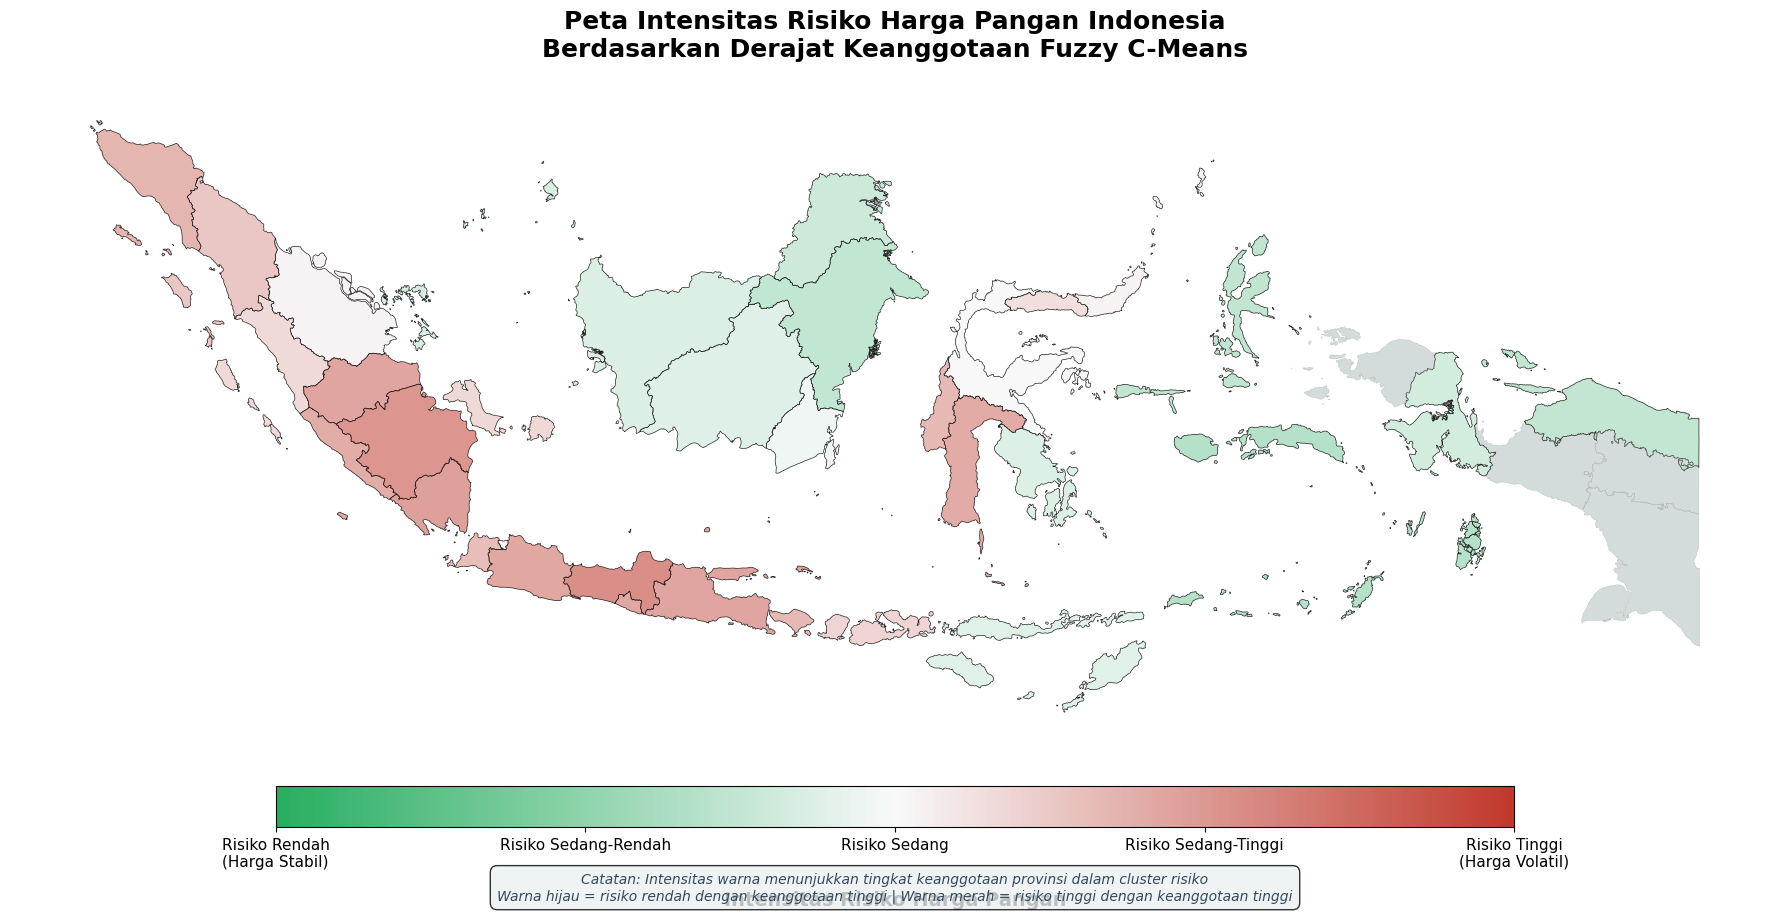

In [24]:
print("\nMembuat peta intensitas keanggotaan...")

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

# Colormap kustom: Hijau → Putih → Merah
colors_gradient = ['#27ae60', '#f8f9fa', '#c0392b']
cmap = LinearSegmentedColormap.from_list('gradien_risiko', colors_gradient, N=256)

# Normalisasi keanggotaan (0 = risiko rendah kuat, 1 = risiko tinggi kuat)
df_map['keanggotaan_norm'] = df_map.apply(
    lambda row: row['keanggotaan'] if row['cluster'] == high_risk_cluster else (1 - row['keanggotaan']),
    axis=1
)

# Lookup untuk gradient
geo_gradient_lookup = {}
for _, row in df_map.iterrows():
    geo_gradient_lookup[row['geo_name']] = row['keanggotaan_norm']

# Gambar provinsi dengan gradient
for feature in indonesia_geo['features']:
    prop = feature['properties']
    geo_name = prop.get('PROVINSI') or prop.get('provinsi') or prop.get('Propinsi')
    geometry = feature['geometry']
    
    if geo_name in geo_gradient_lookup:
        membership_norm = geo_gradient_lookup[geo_name]
        color = cmap(membership_norm)
        alpha = 0.85
        edgecolor = 'black'
        linewidth = 0.5
    elif geo_name in new_provinces:
        color = '#95a5a6'
        alpha = 0.4
        edgecolor = 'gray'
        linewidth = 0.3
    else:
        color = '#ecf0f1'
        alpha = 0.2
        edgecolor = 'lightgray'
        linewidth = 0.3
    
    if geometry['type'] == 'Polygon':
        coords = geometry['coordinates'][0]
        polygon = Polygon(coords, closed=True)
        patch = plt.Polygon(polygon.get_xy(), facecolor=color, alpha=alpha,
                           edgecolor=edgecolor, linewidth=linewidth)
        ax.add_patch(patch)
    
    elif geometry['type'] == 'MultiPolygon':
        for polygon_coords in geometry['coordinates']:
            coords = polygon_coords[0]
            polygon = Polygon(coords, closed=True)
            patch = plt.Polygon(polygon.get_xy(), facecolor=color, alpha=alpha,
                               edgecolor=edgecolor, linewidth=linewidth)
            ax.add_patch(patch)

ax.autoscale()
ax.set_aspect('equal')
ax.axis('off')

# Colorbar dengan label Bahasa Indonesia
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.04, 
                    fraction=0.046, shrink=0.7, aspect=30)
cbar.set_label('Intensitas Risiko Harga Pangan', fontsize=14, weight='bold', labelpad=15)
cbar.ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
cbar.ax.set_xticklabels([
    'Risiko Rendah\n(Harga Stabil)', 
    'Risiko Sedang-Rendah',
    'Risiko Sedang', 
    'Risiko Sedang-Tinggi',
    'Risiko Tinggi\n(Harga Volatil)'
], fontsize=11)

# Judul
plt.title('Peta Intensitas Risiko Harga Pangan Indonesia\n' + 
          'Berdasarkan Derajat Keanggotaan Fuzzy C-Means',
          fontsize=18, weight='bold', pad=25)

# Catatan kaki
plt.figtext(0.5, 0.02, 
            'Catatan: Intensitas warna menunjukkan tingkat keanggotaan provinsi dalam cluster risiko\n' +
            'Warna hijau = risiko rendah dengan keanggotaan tinggi | Warna merah = risiko tinggi dengan keanggotaan tinggi',
            ha='center', fontsize=10, style='italic', color='#34495e',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#ecf0f1', alpha=0.8))

plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'peta_intensitas_keanggotaan.png', dpi=300, bbox_inches='tight')
print(f"✓ Tersimpan: peta_intensitas_keanggotaan.png")
plt.show()

In [25]:
print("\nMembuat ringkasan regional...")

# Definisi regional
region_mapping = {
    'Sumatera': ['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi', 
                 'Sumatera Selatan', 'Bengkulu', 'Lampung', 'Kepulauan Bangka Belitung', 
                 'Kepulauan Riau'],
    'Jawa-Bali': ['DKI Jakarta', 'Jawa Barat', 'Jawa Tengah', 'DI Yogyakarta', 
                  'Jawa Timur', 'Banten', 'Bali'],
    'Kalimantan': ['Kalimantan Barat', 'Kalimantan Tengah', 'Kalimantan Selatan', 
                   'Kalimantan Timur', 'Kalimantan Utara'],
    'Sulawesi': ['Sulawesi Utara', 'Sulawesi Tengah', 'Sulawesi Selatan', 
                 'Sulawesi Tenggara', 'Gorontalo', 'Sulawesi Barat'],
    'Nusa Tenggara': ['Nusa Tenggara Barat', 'Nusa Tenggara Timur'],
    'Maluku & Papua': ['Maluku', 'Maluku Utara', 'Papua', 'Papua Barat']
}

regional_stats = []
for region, prov_list in region_mapping.items():
    region_df = df_map[df_map['provinsi'].isin(prov_list)]
    
    if len(region_df) > 0:
        high_risk_count = region_df[region_df['label_risiko']=='Risiko Tinggi'].shape[0]
        low_risk_count = region_df[region_df['label_risiko']=='Risiko Rendah'].shape[0]
        fuzzy_count = region_df[region_df['is_fuzzy']].shape[0]
        avg_membership = region_df['keanggotaan'].mean()
        
        # Persentase risiko tinggi
        high_pct = (high_risk_count / len(region_df)) * 100
        
        regional_stats.append({
            'Wilayah': region,
            'Total_Provinsi': len(region_df),
            'Risiko_Tinggi': high_risk_count,
            'Risiko_Rendah': low_risk_count,
            'Fuzzy': fuzzy_count,
            'Persen_Risiko_Tinggi': f'{high_pct:.1f}%',
            'Rata_Rata_Keanggotaan': f'{avg_membership:.3f}'
        })

df_regional = pd.DataFrame(regional_stats)

# Urutkan berdasarkan persentase risiko tinggi
df_regional['sort_key'] = df_regional['Persen_Risiko_Tinggi'].str.rstrip('%').astype(float)
df_regional = df_regional.sort_values('sort_key', ascending=False).drop('sort_key', axis=1)

df_regional.to_csv(OUTPUT_DIR + 'ringkasan_cluster_regional.csv', index=False)
print(f"✓ Tersimpan: ringkasan_cluster_regional.csv")

print("\n" + "="*80)
print("RINGKASAN REGIONAL KERAWANAN PANGAN")
print("="*80)
print(df_regional.to_string(index=False))


Membuat ringkasan regional...
✓ Tersimpan: ringkasan_cluster_regional.csv

RINGKASAN REGIONAL KERAWANAN PANGAN
       Wilayah  Total_Provinsi  Risiko_Tinggi  Risiko_Rendah  Fuzzy Persen_Risiko_Tinggi Rata_Rata_Keanggotaan
     Jawa-Bali               7              7              0      6               100.0%                 0.710
      Sumatera              10              9              1      9                90.0%                 0.674
      Sulawesi               6              5              1      6                83.3%                 0.604
 Nusa Tenggara               2              1              1      2                50.0%                 0.592
    Kalimantan               5              0              5      5                 0.0%                 0.592
Maluku & Papua               4              0              4      4                 0.0%                 0.652
